In [1]:
import requests
import pandas as pd
from bfxapi import Client
from datetime import datetime
import missingno
import os

In [12]:
async def bitfinex_data(asset: str):
    BfxRest = Client()
    output_df = pd.DataFrame(index=pd.date_range(start=datetime(2013, 1, 1),  freq='1H', end=datetime.now()))

    iters = 0
    timestamp_now = datetime.now().timestamp() *1000
    num = 36000000000
    
    data_list = []
    while True:
        end = timestamp_now - num*iters
        start = end - num
        data = await BfxRest.rest.get_public_candles(asset, start, end, section='hist', tf='1h', limit='10000', sort=-1)
        if len(data) == 0:
            break
        
        data_list.extend(data)
        iters += 1

    df= pd.DataFrame(data_list, columns=['date', 'open', 'close', 'high', 'low', 'volume'])
    df['date'] = pd.to_datetime(df['date'],unit='ms')
    df.set_index('date', inplace=True)
    df.sort_index(ascending=False, inplace=True)
    output_df = output_df.join(df)

    return output_df

def chain_data(asset: str):

    API_KEY = os.getenv('GLASSNODE_KEY')

    request_dict = {"BLOCK_SIZE": 'blockchain/block_size_sum',
                    "HASH_RATE": "mining/hash_rate_mean",
                    "DIFFICULTY": "mining/difficulty_latest",
                    "TRANSACTION_RATE": "transactions/rate",
                    "ACTIVE_ADDRESSES": "addresses/active_count",
                    "NEW_ADDRESSES": "addresses/new_non_zero_count"}

    main_df = pd.DataFrame(index=pd.date_range(start=datetime(2013, 1, 1), freq='1H', end=datetime.now()))
    for name, url in request_dict.items():
        res = requests.get(f'https://api.glassnode.com/v1/metrics/{url}', params={'a': asset, 'api_key': API_KEY, 'i': '1h'})
        if not res.ok:
            raise Exception(res.text)
        df = pd.DataFrame(res.json()).set_index('t').rename({'v': f'{name}'}, axis=1)
        df.index = pd.to_datetime(df.index, unit='s')
        main_df = main_df.join(df)

    return main_df


### Bitcoin

,open,close,high,low,volume,BLOCK_SIZE,HASH_RATE,DIFFICULTY,TRANSACTION_RATE,ACTIVE_ADDRESSES,NEW_ADDRESSES
2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,762692.0,1.644915e+13,1.279744e+16,0.580556,4577.0,1900.0
2013-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,309878.0,1.216102e+13,1.279744e+16,0.194444,1616.0,647.0
2013-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,484743.0,3.713543e+13,1.279744e+16,0.286111,1594.0,674.0
2013-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,547847.0,2.964945e+13,1.279744e+16,0.274167,2453.0,798.0
2013-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,474038.0,3.707016e+13,1.279744e+16,0.313611,2115.0,869.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-22 16:00:00,23283.000000,23115.706498,23336.000000,23050.0,105.129630,5555072.0,1.471558e+20,1.189387e+23,2.754444,46303.0,15131.0
2022-07-22 17:00:00,23113.659048,23010.000000,23197.567512,22896.0,129.214095,6571754.0,1.459818e+20,1.189387e+23,3.104167,50306.0,17119.0
2022-07-22 18:00:00,23012.492050,23024.968565,23055.000000,22922.0,125.837205,6328518.0,1.258277e+20,1.189387e+23,3.122222,52652.0,17623.0
2022-07-22 19:00:00,23021.000000,22704.000000,23131.000000,22704.0,123.284948,NaN,NaN,NaN,NaN,NaN,NaN


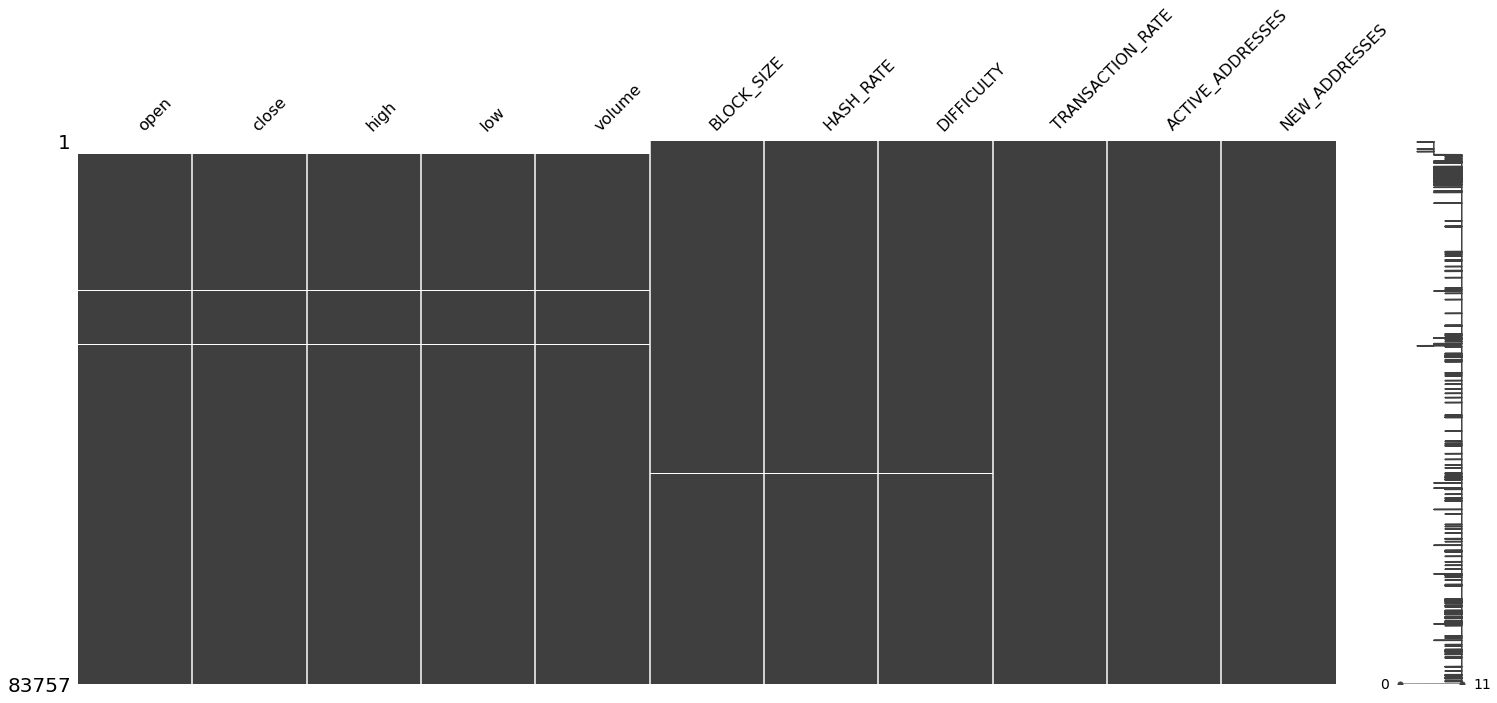

In [14]:
btc_df = await bitfinex_data('tBTCUSD')
onchain_btc_df = chain_data('BTC')
btc_df = btc_df.join(onchain_btc_df).sort_index()
missingno.matrix(btc_df)
btc_df

In [15]:
btc_df[btc_df.isna().any(axis=1)]

,open,close,high,low,volume,BLOCK_SIZE,HASH_RATE,DIFFICULTY,TRANSACTION_RATE,ACTIVE_ADDRESSES,NEW_ADDRESSES
2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,762692.0,1.644915e+13,1.279744e+16,0.580556,4577.0,1900.0
2013-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,309878.0,1.216102e+13,1.279744e+16,0.194444,1616.0,647.0
2013-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,484743.0,3.713543e+13,1.279744e+16,0.286111,1594.0,674.0
2013-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,547847.0,2.964945e+13,1.279744e+16,0.274167,2453.0,798.0
2013-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,474038.0,3.707016e+13,1.279744e+16,0.313611,2115.0,869.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-16 11:00:00,21259.000000,21058.000000,21303.0,20901.0,406.078972,NaN,NaN,NaN,0.000000,0.0,0.0
2022-06-30 14:00:00,18855.000000,19118.218466,19146.0,18848.0,368.585323,NaN,NaN,NaN,0.000000,0.0,0.0
2022-07-04 18:00:00,19896.826637,19920.366941,19967.0,19820.0,67.366927,NaN,NaN,NaN,0.000000,0.0,0.0
2022-07-22 19:00:00,23021.000000,22704.000000,23131.0,22704.0,123.284948,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
btc_df.drop(btc_df.tail(1).index, inplace=True)
btc_df.fillna(method='ffill', inplace=True)

In [17]:
btc_df

,open,close,high,low,volume,BLOCK_SIZE,HASH_RATE,DIFFICULTY,TRANSACTION_RATE,ACTIVE_ADDRESSES,NEW_ADDRESSES
2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,762692.0,1.644915e+13,1.279744e+16,0.580556,4577.0,1900.0
2013-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,309878.0,1.216102e+13,1.279744e+16,0.194444,1616.0,647.0
2013-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,484743.0,3.713543e+13,1.279744e+16,0.286111,1594.0,674.0
2013-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,547847.0,2.964945e+13,1.279744e+16,0.274167,2453.0,798.0
2013-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,474038.0,3.707016e+13,1.279744e+16,0.313611,2115.0,869.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-22 15:00:00,23662.000000,23281.000000,23662.000000,23227.0,299.831923,9423300.0,1.921982e+20,1.189387e+23,4.686944,74166.0,24630.0
2022-07-22 16:00:00,23283.000000,23115.706498,23336.000000,23050.0,105.129630,5555072.0,1.471558e+20,1.189387e+23,2.754444,46303.0,15131.0
2022-07-22 17:00:00,23113.659048,23010.000000,23197.567512,22896.0,129.214095,6571754.0,1.459818e+20,1.189387e+23,3.104167,50306.0,17119.0
2022-07-22 18:00:00,23012.492050,23024.968565,23055.000000,22922.0,125.837205,6328518.0,1.258277e+20,1.189387e+23,3.122222,52652.0,17623.0


<AxesSubplot:>

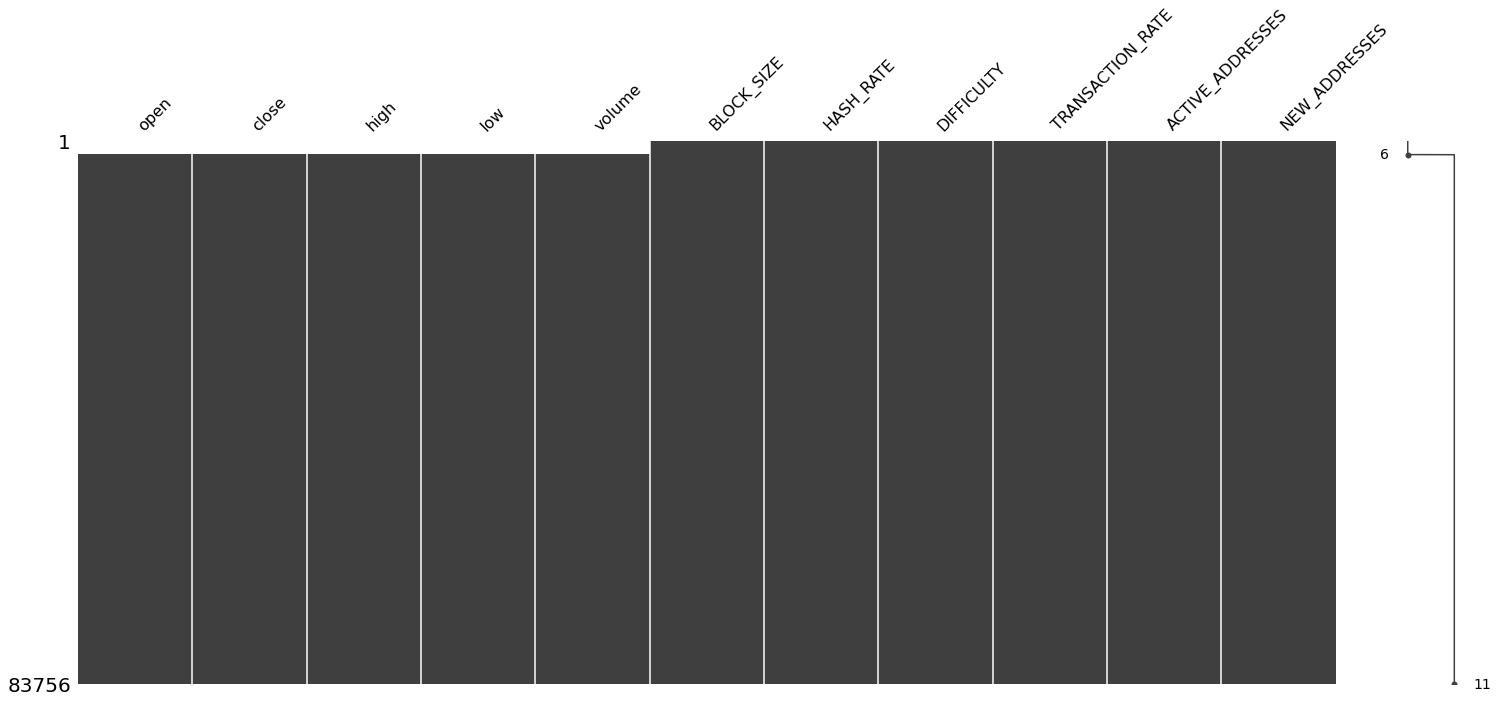

In [26]:
missingno.matrix(btc_df)

In [18]:
btc_df.dropna().to_csv('BTC_Data.csv')

### Ethereum

,open,close,high,low,volume,BLOCK_SIZE,HASH_RATE,DIFFICULTY,TRANSACTION_RATE,ACTIVE_ADDRESSES,NEW_ADDRESSES
2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-22 16:00:00,1574.300000,1581.245361,1584.565637,1563.8,2297.336226,24545851.0,9.488403e+14,1.178222e+16,14.944167,36733.0,3711.0
2022-07-22 17:00:00,1581.245361,1569.192256,1592.284669,1559.0,1385.810203,22794334.0,9.511734e+14,1.196522e+16,13.891389,33544.0,3433.0
2022-07-22 18:00:00,1568.766275,1574.800000,1577.800000,1558.2,1196.980827,18490141.0,8.490513e+14,1.180461e+16,12.288333,31305.0,2946.0
2022-07-22 19:00:00,1574.700000,1546.000000,1578.600000,1543.2,1221.800328,NaN,NaN,NaN,NaN,NaN,NaN


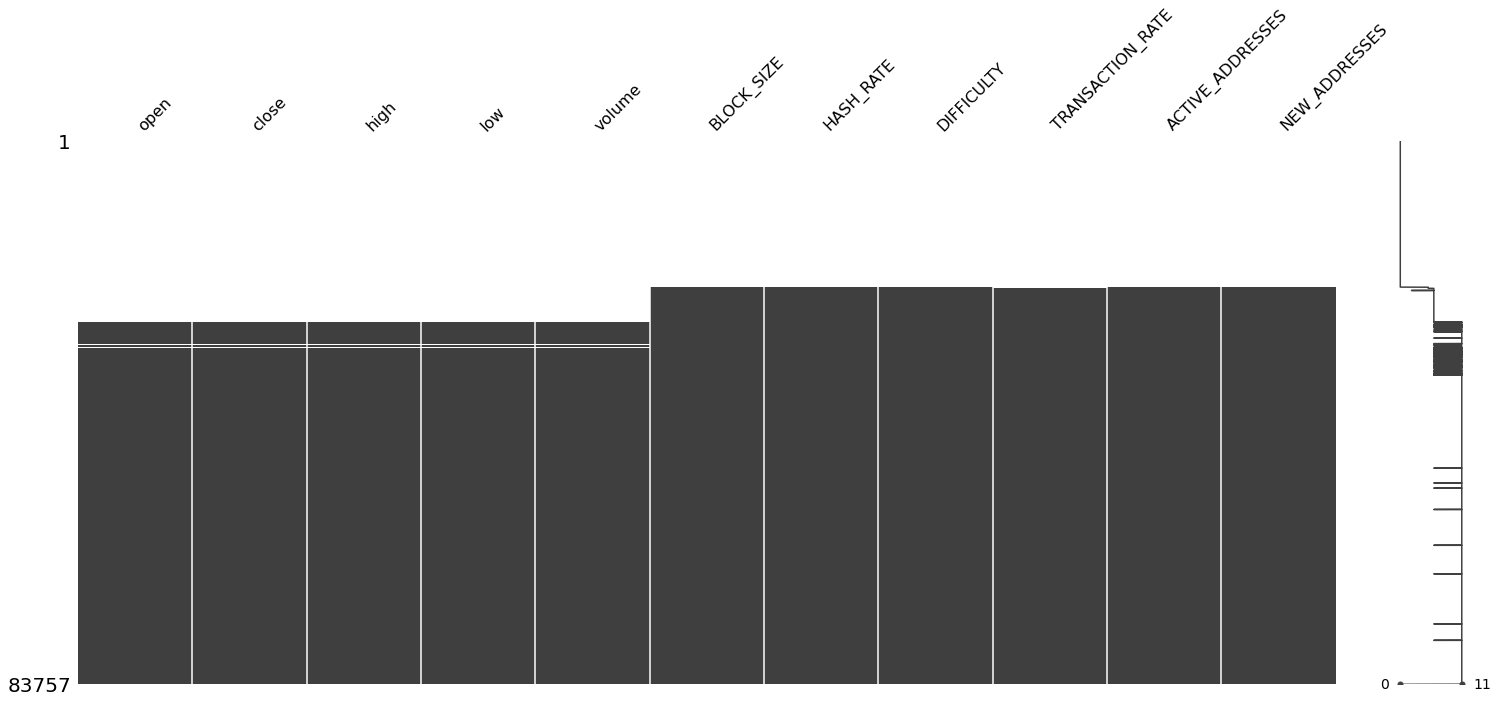

In [21]:
eth_df = await bitfinex_data('tETHUSD')
onchain_eth_df = chain_data('ETH')
eth_df = eth_df.join(onchain_eth_df).sort_index()
missingno.matrix(eth_df)
eth_df

In [22]:
eth_df.drop(eth_df.tail(1).index, inplace=True)
eth_df.fillna(method='ffill', inplace=True)

In [23]:
eth_df

,open,close,high,low,volume,BLOCK_SIZE,HASH_RATE,DIFFICULTY,TRANSACTION_RATE,ACTIVE_ADDRESSES,NEW_ADDRESSES
2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-22 15:00:00,1611.785171,1574.500000,1613.255375,1569.773176,2068.459204,22954350.0,8.519910e+14,1.155065e+16,13.433611,33377.0,3041.0
2022-07-22 16:00:00,1574.300000,1581.245361,1584.565637,1563.800000,2297.336226,24545851.0,9.488403e+14,1.178222e+16,14.944167,36733.0,3711.0
2022-07-22 17:00:00,1581.245361,1569.192256,1592.284669,1559.000000,1385.810203,22794334.0,9.511734e+14,1.196522e+16,13.891389,33544.0,3433.0
2022-07-22 18:00:00,1568.766275,1574.800000,1577.800000,1558.200000,1196.980827,18490141.0,8.490513e+14,1.180461e+16,12.288333,31305.0,2946.0


In [24]:
eth_df.dropna().to_csv('ETH_Data.csv')

<AxesSubplot:>

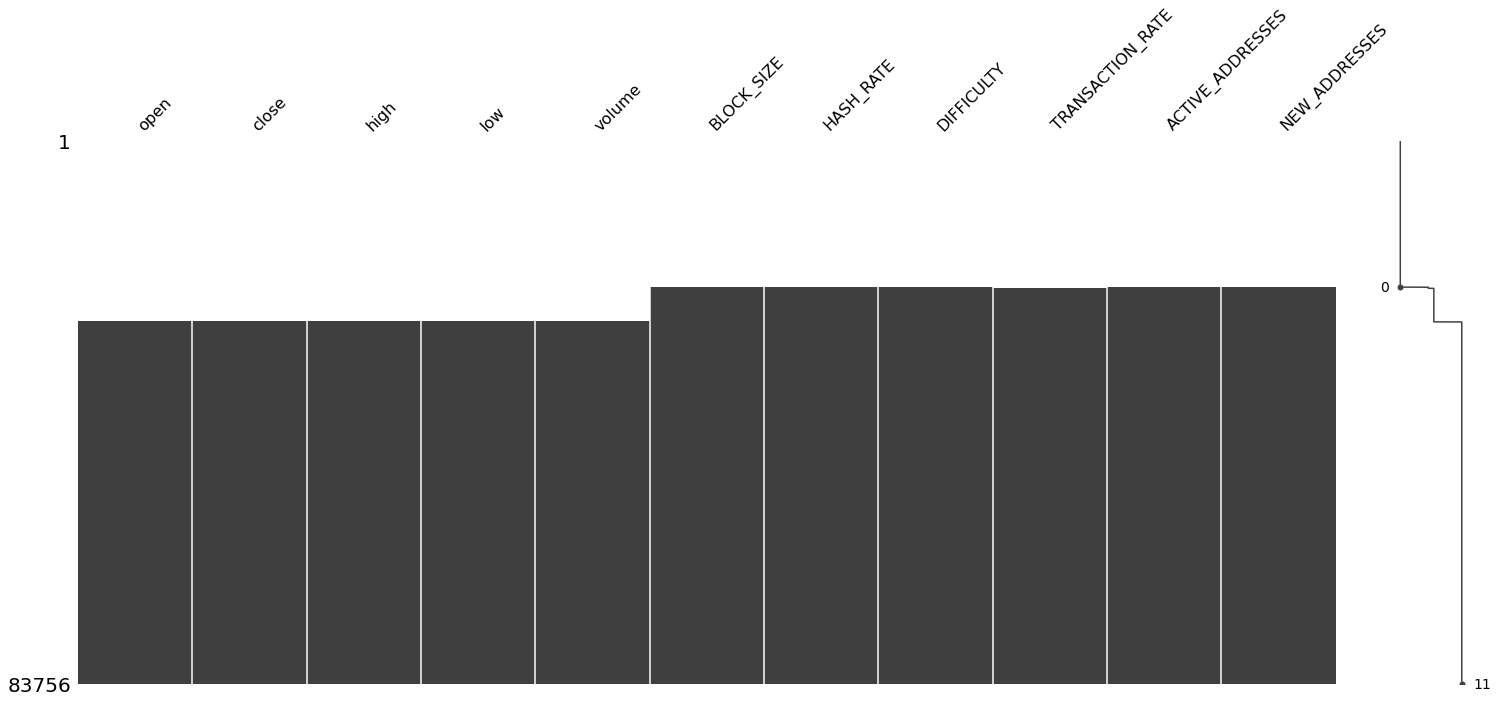

In [25]:
missingno.matrix(eth_df)